# Response to Reviewers
This notebook run additional analyses to address the reviewers' comments.

### imports and setups

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import (GridSearchCV, GroupShuffleSplit,
                                     StratifiedGroupKFold, cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVR, SVR
from tqdm import tqdm

from src.sugnet.pipeline import FeatureExtractor

In [2]:
# functions
def classification_with_nestedCV(kind, frequency_band, X, y, groups, n_splits_outer=50, n_splits_inner=5):
    y_preds = []

    # Choose cross-validation techniques for the inner and outer loops
    outer_cv = GroupShuffleSplit(n_splits=n_splits_outer, test_size=0.3)
    inner_cv = GroupShuffleSplit(n_splits=n_splits_inner, test_size=0.2)

    # PIPELINE
    pipe = Pipeline(steps=[
    ('extract', FeatureExtractor()),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])
    
    # grid search
    grid_params = [{
        'extract__kind': [kind],
        'extract__frequency_band': [frequency_band],
    }]
    
    test_accuraies = []
    for train, test in outer_cv.split(X, y, groups):

        # Nested CV with parameter optimization
        grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
        grid.fit(X[train], y[train], groups=groups.iloc[train])
        
        # accrucy on the test set using the best estimator
        y_pred = grid.predict(X[test])
        y_preds.append(y_pred)
        test_accuraies.append((y[test] == y_pred).mean())
        
    return test_accuraies, y_preds

## Descriptive statistics

Text(0.5, 1.0, 'Hypnotizability Distribution')

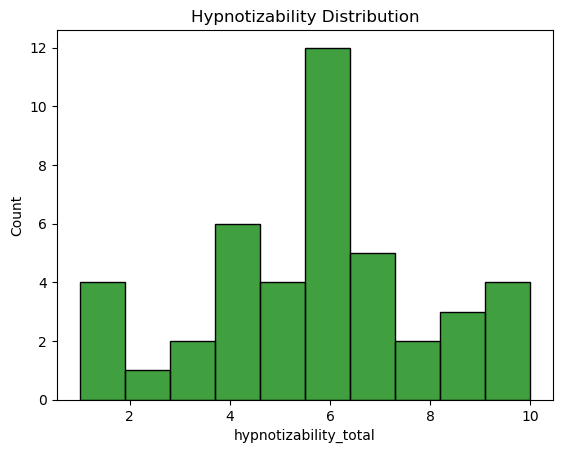

In [15]:
# open hypnotizability data
hypnotizability = pd.read_excel('data/behavioral_data/PLB_HYP_data_MASTER.xlsx').loc[9:, ['hypnotizability_total', 'bids_id']]
# hypnotizability histogram
sns.histplot(data=hypnotizability, x='hypnotizability_total', bins=10, color='green')
plt.title('Hypnotizability Distribution')

In [16]:
hypnotizability['hypnotizability_total'].describe()

count    43.00000
mean      5.72093
std       2.50072
min       1.00000
25%       4.00000
50%       6.00000
75%       7.00000
max      10.00000
Name: hypnotizability_total, dtype: float64

Text(0.5, 1.0, 'Hypnosis depth')

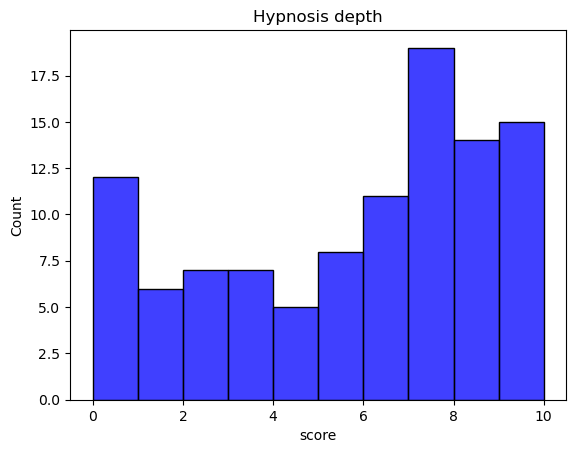

In [100]:
# open behavioral data in long format
data = pd.read_csv('data/behavioral_data/behavioral_data.csv')
data = data.query("description == 'hypnosis'")

# hypnosis depth histogram
sns.histplot(data=data, x='score', bins=10, color='blue')
plt.title('Hypnosis depth')

In [103]:
# the correlation between hypnotizability scores and hypnosis depth in all the conditions
data = pd.read_csv('data/behavioral_data/behavioral_data.csv')
data = data.query("description == 'hypnosis'").reset_index(drop=True)

hypnotizability = pd.read_excel('data/behavioral_data/PLB_HYP_data_MASTER.xlsx').loc[9:, ['bids_id', 'hypnotizability_total']]
hypnotizability = hypnotizability.loc[hypnotizability.index.repeat(2)].reset_index(drop=True)
data = pd.concat([data, hypnotizability], axis=1).dropna().reset_index(drop=True)
data[['hypnotizability_total', 'score']].corr()

,hypnotizability_total,score
hypnotizability_total,1.000000,0.580162
score,0.580162,1.000000


<Axes: xlabel='hypnotizability_total', ylabel='score'>

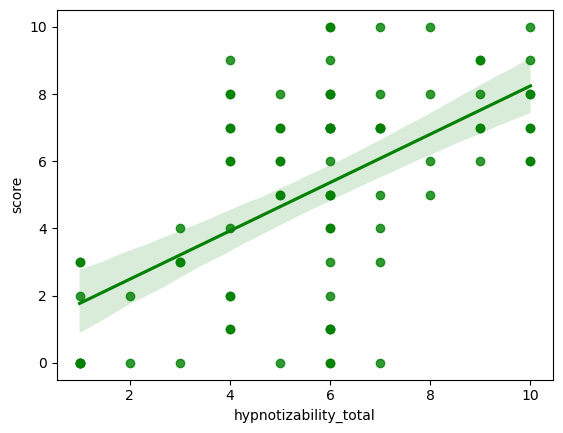

In [105]:
sns.regplot(data=data, x='hypnotizability_total', y='score', color='green')

## Using hypnotizability scores
In this section, we use the extracted features from the brain to predict hypnotizability classes. We use the same features and models as in the main paper, but instead of using hypnosis depth as the target variable, we use the hypnotizability scores.

### Load data

In [3]:
# 1. open hypnotizability data
hypnotizability = pd.read_excel('data/behavioral_data/PLB_HYP_data_MASTER.xlsx').loc[9:, ['hypnotizability_total', 'bids_id']]
hypnotizability = hypnotizability.loc[hypnotizability.index.repeat(4)].reindex()
hypnotizability['bids_id'] = hypnotizability['bids_id'].astype(int)
hypnotizability = hypnotizability.iloc[:-2].reset_index(drop=True)

# 2. open behavioral data
# 1. Data
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)
DATA = DATA.query('condition.str.contains("experience")').reset_index(drop=True)

# 3. check if the order in the bids_id columns are the same across the two dataframes
if hypnotizability['bids_id'].equals(DATA['bids_id']):
    hypnotizability.drop(columns=['bids_id'], inplace=True)
    
    # 4. merge two dataframes
    DATA = pd.concat([DATA, hypnotizability], axis=1)
    DATA = DATA.query('description == "hypnosis"')
    DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))
else:
    print('The order of the bids_id columns are not the same across the two dataframes.')

### Analysis 1: multiclass classification + hypnotizability + conditions:labeled as hypnosis

In [ ]:
# 5. Xy
DATA.dropna(inplace=True)
X = DATA[['bids_id','procedure']].values
y = DATA['hypnotizability_total'].apply(lambda x: 'low' if x <= 3 else ('high' if x>=9 else 'medium')).values
groups = DATA['bids_id']

# 6. nested cross validation
kind = 'power sensor'
frequency_band = 'gamma'
models_test_accuraies, y_preds = classification_with_nestedCV(kind, frequency_band, X, y, groups)

In [14]:
print('>>> accuracy=', np.array(models_test_accuraies).mean())

unique, counts = np.unique(y, return_counts=True) 
unique_groups = dict(zip(unique, counts))
print('>>> chance_level=', unique_groups['medium'] / len(y) * 100)

>>> accuracy= 0.6095692307692308
>>> chancle_level= 68.23529411764706


### Analysis 2: multiclass classification + conditions: only real hypnosis

In [21]:
# only include real hypnosis procedures
DATA2 = DATA.query('procedure == "relaxation" or procedure == "confusion"')

# 5. Xy
X = DATA2[['bids_id', 'procedure']].values
y = DATA2['hypnotizability_total'].apply(lambda x: 'low' if x <= 3 else ('high' if x>=9 else 'medium')).values
groups = DATA2['bids_id']

# 6. nested cross validation
kind = 'correlation source'
frequency_band = 'beta'
models_test_accuraies, y_preds = classification_with_nestedCV(kind, frequency_band, X, y, groups)

print('>>> accuracy=', np.array(models_test_accuraies).mean())

unique, counts = np.unique(y, return_counts=True) 
unique_groups = dict(zip(unique, counts))
print('>>> chance_level=', unique_groups['medium'] / len(y) * 100)

  0%|          | 0/1 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>correlation source (beta)<<<<<<<<<<<<<<<<<<


  0%|          | 0/1 [00:12<?, ?it/s]


### Analysis 3: regression + hypnosis depth + conditions: labeled as hypnosis

In [11]:
import random
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

In [53]:
# regression using xgboost

params = {
    "n_estimators": 100,
    "max_depth": 4,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

# 5. Xy
X = DATA[['bids_id', 'procedure']].values
y = DATA['hypnosis_depth'].values
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1).values
groups = DATA['bids_id']

mse_all = []
r2_all = []
cv = GroupShuffleSplit(50, test_size=0.3)

# PIPELINE
pipe = Pipeline(steps=[
('extract', FeatureExtractor(kind='power sensor', frequency_band='gamma')),
('zerovar', VarianceThreshold(threshold=0.0)),
('scale', StandardScaler()),
# ('regr', GradientBoostingRegressor(**params)),
# ('regr', SVR(kernel='linear', C=1, gamma=0.1)),
('cls', SVC(kernel='linear', max_iter=1000000)),
])

test_scores= []
y_preds = []
accuracys = []
for train, test in cv.split(X, y, groups):
    # random.shuffle(y)
    pipe.fit(X[train], y[train])
    y_pred = pipe.predict(X[test])
    y_preds.append(y_pred)
    accuracys.append((y[test] == y_pred).mean())
    # accuracys.append(y[test] == pipe.predict(X[test]).mean())
    test_scores.append(pipe.score(X[test], y[test]))
    # mse = mean_squared_error(y[train], pipe.predict(X[train]))
    # percetage_error = mape(y[test], pipe.predict(X[test]))
    # r2 = r2_score(y[test], pipe.predict(X[test]))

    # mse_all.append(mse)
    # r2_all.append(r2)

np.array(test_scores).mean()

0.5222983870967741

In [56]:
unique, count = np.unique(y, return_counts=True)
unique_groups = dict(zip(unique, count))
unique_groups[1] / len(y) * 100

57.28155339805825

In [8]:
X = DATA[['bids_id', 'procedure']].values
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1).values

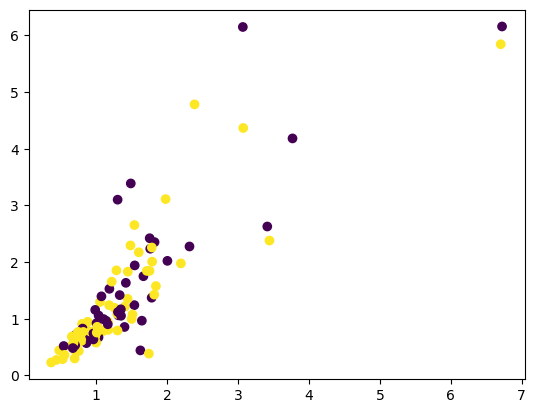

In [64]:
powers = FeatureExtractor(kind='power sensor', frequency_band='theta').transform(X, y)
plt.scatter(powers['FZ_theta'], powers['PZ_theta'], c=y_, cmap='viridis')

In [ ]:
feature_importance = pipe.named_steps['regr'].feature_importances_
feature_names = FeatureExtractor(kind='power sensor', frequency_band='gamma').transform(X, y).columns

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

### Analysis 4: using raletive powers

In [55]:
from sklearn.metrics import mean_squared_error, r2_score

In [66]:
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)
DATA = DATA.query('condition.str.contains("experience")').reset_index(drop=True)
DATA = DATA.query('description == "hypnosis"')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))


DATA['is_it_real'] = DATA['procedure'].apply(lambda x: 'real' if x == 'relaxation' or x == 'confusion' else 'sham')
X = DATA.query('is_it_real == "real"')[['bids_id','procedure']].values
groups = DATA.query('is_it_real == "real"')['bids_id']

DATA.set_index('bids_id', inplace=True)
sham = DATA.query('is_it_real == "sham"')['hypnosis_depth']
real = DATA.query('is_it_real == "real"')['hypnosis_depth']

y = (real+1)/(sham+1)[:-1]  # last participants does not have real condition
y = y.values

In [73]:
# regression using xgboost

params = {
    "n_estimators": 100,
    "max_depth": 4,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

mse_all = []
r2_all = []
cv = GroupShuffleSplit(50, test_size=0.3)

# PIPELINE
pipe = Pipeline(steps=[
('extract', FeatureExtractor(kind='power sensor relative to sham', frequency_band='gamma')),
('zerovar', VarianceThreshold(threshold=0.0)),
('scale', StandardScaler()),
# ('regr', GradientBoostingRegressor(**params)),
('regr', SVR(kernel='linear', C=1, gamma=0.1)),
])

import random
test_scores= []
for train, test in cv.split(X, y, groups):
    # random.shuffle(y)
    pipe.fit(X[train], y[train])
    accuracys.append((y[test] == y_pred).mean())
    mse = mean_squared_error(y[train], pipe.predict(X[train]))
    r2 = r2_score(y[test], pipe.predict(X[test]))

    mse_all.append(mse)
    r2_all.append(r2)

np.array(mse_all).mean()

2.3424412341250993

### Analysis 5: interaction effects and effect sizes in ANOVAs

In [3]:
%reload_ext autoreload
%autoreload 3
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import pingouin as pg

In [4]:
DATA = pd.read_excel('data/PLB_HYP_data_MASTER.xlsx')
DATA = DATA.dropna(subset='bids_id') # drop the first 9 participants

# Wide to Long
DATA = DATA.melt(id_vars=[
                          'procedure_type_1', 'procedure_type_2', 'procedure_type_3', 'procedure_type_4', 'bids_id',
                          'description_type_1', 'description_type_2', 'description_type_3', 'description_type_4',
                          'hypnosis_depth_1', 'hypnosis_depth_2', 'hypnosis_depth_3', 'hypnosis_depth_4',
                          'trial_type_1', 'trial_type_2', 'trial_type_3', 'trial_type_4'
                          ],
                 value_vars=['expectancy_1', 'expectancy_2', 'expectancy_3', 'expectancy_4']
                 )

DATA['session'] = DATA['variable'].apply(lambda x:x.split('_')[1])
DATA['procedure'] = DATA.apply(lambda r:r['procedure_type_'+r['session']], axis=1)
DATA['description'] = DATA.apply(lambda r:r['description_type_'+r['session']], axis=1)
DATA['hypnosis_depth'] = DATA.apply(lambda r:r['hypnosis_depth_'+r['session']], axis=1)
DATA['trial_type'] = DATA.apply(lambda r:r['trial_type_'+r['session']], axis=1)

DATA = DATA[['bids_id', 'session', 'trial_type', 'procedure', 'description', 'value', 'hypnosis_depth',]].sort_values(by=['bids_id', 'session'])
DATA = DATA.rename(columns={'value': 'expectancy'})
DATA.reset_index(drop=True, inplace=True)

# replace true values with strings (having boolean values will affect ANOVA result)
DATA = DATA.replace({True: 'real'})

In [9]:
# two-ways anova 
aov = pg.anova(data=DATA, dv='hypnosis_depth', between=['trial_type', 'description'], detailed=True)
aov.round(4)

,Source,SS,DF,MS,F,p-unc,np2
0,trial_type,55.0433,1,55.0433,6.5706,0.0111,0.0312
1,description,374.2356,1,374.2356,44.6733,0.0000,0.1796
2,trial_type * description,2.5433,1,2.5433,0.3036,0.5822,0.0015
3,Residual,1708.9423,204,8.3772,NaN,NaN,NaN


In [10]:
aov = pg.anova(data=DATA, dv='expectancy', between=['trial_type', 'description'], detailed=True)
aov.round(4)

,Source,SS,DF,MS,F,p-unc,np2
0,trial_type,0.2356,1,0.2356,0.0419,0.8380,0.0002
1,description,612.7356,1,612.7356,109.0605,0.0000,0.3484
2,trial_type * description,3.0048,1,3.0048,0.5348,0.4654,0.0026
3,Residual,1146.1346,204,5.6183,NaN,NaN,NaN
